In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
# load npz file

train_data = np.load("/content/drive/MyDrive/capstone/npz/train_data.npz")
data = np.load("/content/drive/MyDrive/capstone/npz/val_data.npz")
test_data = np.load("/content/drive/MyDrive/capstone/npz/test_data.npz")

In [ ]:
X_train = train_data['X']
y_train = train_data['Y']

X_val = data['X']
y_val = data['Y']

X_test = test_data['X']
y_test = test_data['Y']

In [ ]:
def preprocess_images(X):
    X_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X])
    X_gray = X_gray / 255.0  # Normalize pixel values
    return X_gray.reshape(-1, 240, 240, 1)  # Reshape for CNN input

X_train_gray = preprocess_images(X_train)
X_val_gray = preprocess_images(X_val)
X_test_gray = preprocess_images(X_test)

In [ ]:
# Encode labels consistently across datasets
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

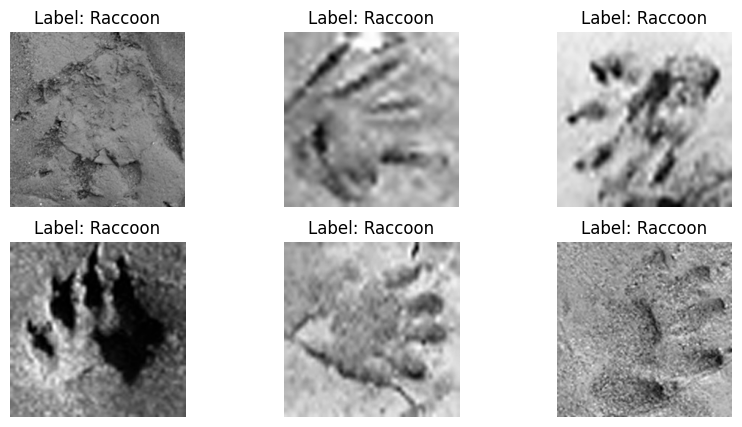

In [ ]:
# display some sample images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train_gray[i].reshape(240, 240), cmap="gray")
    plt.axis('off')
    plt.title(f"Label: {label_encoder.inverse_transform([np.argmax(y_train_one_hot[i])])[0]}")
plt.show()

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(240, 240, 1)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(y_train_one_hot.shape[1], activation='softmax')  # Output layer
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 819s 6s/step - accuracy: 0.0683 - loss: 2.9381 - val_accuracy: 0.1069 - val_loss: 2.8625 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 859s 6s/step - accuracy: 0.0690 - loss: 2.8801 - val_accuracy: 0.1069 - val_loss: 2.8455 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 793s 6s/step - accuracy: 0.0854 - loss: 2.8668 - val_accuracy: 0.1069 - val_loss: 2.8641 - learning_rate: 0.0010
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 795s 6s/step - accuracy: 0.0822 - loss: 2.8712 - val_accuracy: 0.1069 - val_loss: 2.8512 - learning_rate: 0.0010
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0801 - loss: 2.8634
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
133/133 ━━━━━━━━━━━━━━━━━━━━ 849s 6s/step - accuracy: 0.0801 - loss: 2.8635 - val_accuracy: 0.1069 - val_loss: 2.8481 - learning_rate: 0.0010
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 819s 6s/step - accuracy: 0.0810 - loss: 2.858

Text(0.5, 1.0, 'Training Performance')

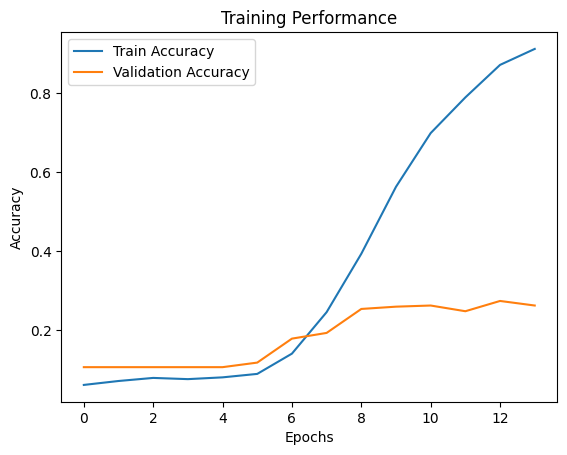

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train_gray, y_train_one_hot, batch_size=32,
    validation_data=(X_val_gray, y_val_one_hot),
    epochs=20,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(X_test_gray, y_test_one_hot)
print(f"Test Accuracy: {test_acc:.4f}")

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Performance")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - accuracy: 0.0798 - loss: 3.4048 - val_accuracy: 0.1301 - val_loss: 2.8589
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - accuracy: 0.1072 - loss: 2.8080 - val_accuracy: 0.1387 - val_loss: 2.8501
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 564s 4s/step - accuracy: 0.2219 - loss: 2.5686 - val_accuracy: 0.1416 - val_loss: 2.7413
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 559s 4s/step - accuracy: 0.3703 - loss: 2.1229 - val_accuracy: 0.1821 - val_loss: 2.8268
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.5385 - loss: 1.5707 - val_accuracy: 0.1821 - val_loss: 3.0640
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 559s 4s/step - accuracy: 0.6979 - loss: 1.0862 - val_accuracy: 0.2168 - val_loss: 3.2706
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.7735 - loss: 0.7810 - val_accuracy: 0.1821 - val_loss: 3.6439
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - accuracy: 0.8549 - loss: 0.5455 - val_accu

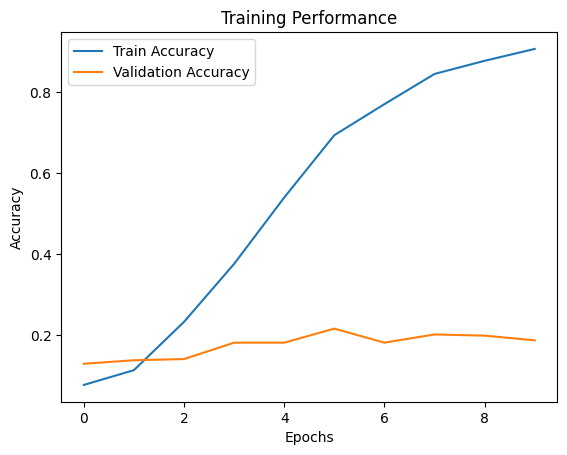

In [ ]:
# # Build a simple CNN model
# model = Sequential([
#     Conv2D(32, (3,3), activation='relu', input_shape=(240, 240, 1)),
#     MaxPooling2D(pool_size=(2,2)),

#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(pool_size=(2,2)),

#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(y_train_one_hot.shape[1], activation='softmax')  # Output layer
# ])

# # Compile the model
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# # Train the model
# history = model.fit(X_train_gray, y_train_one_hot, validation_data=(X_val_gray, y_val_one_hot), epochs=10, batch_size=32)

# # Evaluate on test set
# test_loss, test_acc = model.evaluate(X_test, Y_test)
# print(f"Test Accuracy: {test_acc:.4f}")

# # Plot training history
# plt.plot(history.history["accuracy"], label="Train Accuracy")
# plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
# plt.legend()
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.title("Training Performance")
# plt.show()